In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.stats import linregress as linreg

import scipy.fftpack as fft


from scipy.io import loadmat
from pytex import *

#from scipy.linalg import toeplitz, circulant
#import sympy as smp

In [2]:
matplotlib.rcParams.update({'font.size': 10})

# 1

In [12]:
table = loadmat('hw04_matlab/timings.mat')['table']
table = np.array(table).T
latex_table(table, ['$k$', '$m^2$', 'GE', 'SOR', 'Sparse GE', 'DST', 'Multigrid'])

	\begin{center}
		\begin{tabular}{|c|c|c|c|c|c|c|}
			\hline
			$k$&$m^2$&GE&SOR&Sparse GE&DST&Multigrid\\ \hline
			3&49&0.0006967&0.0008175&0.0004143&0.0003157&0.0019262\\ \hline
			4&225&0.0037434&0.0023273&0.0007004&0.0003316&0.0030616\\ \hline
			5&961&0.018593&0.0078251&0.0015111&0.0004459&0.0052118\\ \hline
			6&3969&0.57195&0.052586&0.0056945&0.0009885&0.009997\\ \hline
			7&16129&41.263&0.44997&0.027005&0.0020163&0.026672\\ \hline
			8&65025&2808.4&4.2597&0.12434&0.0061616&0.078019\\ \hline
			9&2.6112e+05&1.8377e+05&38.512&0.67354&0.0324&0.41839\\ \hline
			10&1.0465e+06&1.1862e+07&531.5&3.0856&0.13551&2.385\\ \hline
		\end{tabular}
	\end{center}


In [10]:
print(10**6/(60*60*24))

11.574074074074074


# 3

In [3]:
def foo(x,y):
    return -8*np.pi**2*np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

def exact(x,y):
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

In [14]:
def fd2poissondct(forcing, a, b, m):
    h = (b-a)/(m+1)
    xs = np.linspace(a, b, m+2)
    X, Y = np.meshgrid(xs, xs)
    fs = forcing(X, Y)
    # fhat=(S*f)*S^(-1)
    f_hat = fft.idct(fft.dct(fs, type=1, axis=0)/2,type=1, axis=1)/(m+1)
    cos_vec = np.cos(np.pi*np.arange(0,m+2)/(m+1))
    denom = 2*(np.add.outer(cos_vec, cos_vec)-2)
    denom[0,0] = 1 #temporary to allow for the division
    u_hat = h**2 * f_hat / denom
    u_hat[0,0] = 0 # arbitrarily chosen
    us = fft.dct(fft.idct(u_hat, type=1, axis=0)/(m+1),type=1, axis=1)/2
    return us

In [20]:
m = 2**6-1
a, b = 0, 1

us = fd2poissondct(foo, a, b, m)
xs = np.linspace(a, b, m+2)
X, Y = np.meshgrid(xs, xs)
u_true = exact(X,Y)
error = la.norm(us - u_true)/ la.norm(u_true)
print(error)

0.000803578


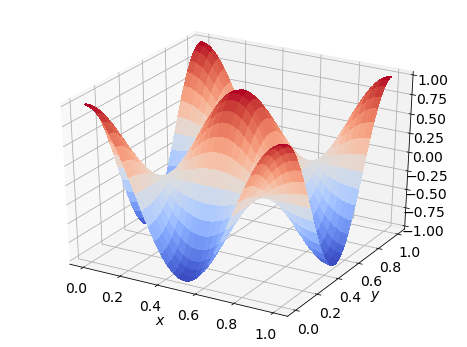

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#fig.colorbar(surf)
plt.show()

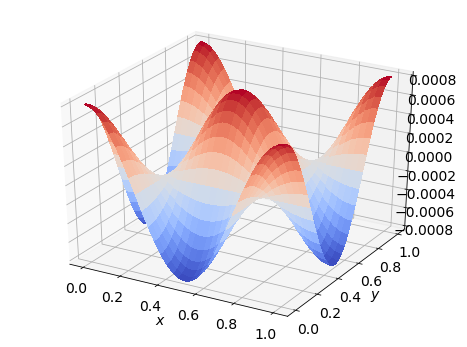

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, us-u_true, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#fig.colorbar(surf)
plt.show()

In [26]:
ks = range(4,11)
ms = [2**k-1 for k in ks]
a, b = 0, 1

errors = []

for m in ms:
    us = fd2poissondct(foo, a, b, m)
    xs = np.linspace(a, b, m+2)
    X, Y = np.meshgrid(xs, xs)
    u_true = exact(X,Y)
    error = la.norm(us - u_true)/ la.norm(u_true)
    errors.append(error)
    
ratios = ['-'] + [e1/e2 for e1,e2 in zip(errors[:-1], errors[1:])]
print(latex_table([ks, ms, errors, ratios], ['$k$', '$m=2^k-1$', 'Relative $L^2$ Error', 'ratio']))

	\begin{center}
		\begin{tabular}{|c|c|c|c|}
			\hline
			$k$&$m=2^k-1$&Relative $L^2$ Error&ratio\\ \hline
			4&15&0.012951&-\\ \hline
			5&31&0.003219&4.0233\\ \hline
			6&63&0.00080358&4.0058\\ \hline
			7&127&0.00020082&4.0014\\ \hline
			8&255&5.0201e-05&4.0004\\ \hline
			9&511&1.255e-05&4.0001\\ \hline
			10&1023&3.1375e-06&4\\ \hline
		\end{tabular}
	\end{center}
None


# 4

In [15]:
def forcing(x,y):
    temp = 2*np.pi*(x+2*y)
    return 10*np.pi**2 * np.exp(np.sin(temp)) * (-2*np.sin(temp) + np.cos(2*temp)+1)
                                
def boundary(x,y):
    return np.exp(np.sin(2*np.pi*(x+2*y)))
exact = boundary

In [34]:
def fd2_poisson_compact(forcing, boundary, a, b, m):
    h = (b-a)/(m+1)

    diagonals = [4.0, -20, 4]
    main_diag_val = sp.diags(diagonals, [-1,0,1], shape=(m,m), format='csr')
    main_diag_loc = sp.eye(m)
    diagonals = [1, 4, 1]
    sub_diag_val = sp.diags(diagonals, [-1,0,1], shape=(m,m), format='csr')
    sub_diag_loc = sp.diags([1,0,1], [-1, 0, 1], shape=(m,m), format='csr')

    M = sp.kron(main_diag_val, main_diag_loc) + sp.kron(sub_diag_val, sub_diag_loc)

    xs = np.linspace(a,b,m+2, endpoint=True)
    X,Y = np.meshgrid(xs,xs)

    fs = forcing(X,Y)
    us = boundary(X,Y)
    us[1:-1,1:-1] = np.zeros((m,m))

    rhs = np.zeros((m,m))
    # sum fs
    rhs +=   fs[1:-1,  :-2] # North
    rhs +=   fs[1:-1, 2:  ] # South
    rhs +=   fs[2:  , 1:-1] # East
    rhs +=   fs[:-2 , 1:-1] # West
    rhs += 8*fs[1:-1, 1:-1] # Center
    rhs *= h**2/2

    # account for boundary conditions
    # corners
    rhs_b = np.zeros((m,m))
    rhs_b += us[:-2,  :-2] # North-west
    rhs_b += us[:-2, 2:  ] # North-east
    rhs_b += us[2: ,  :-2] # South-west
    rhs_b += us[2: , 2:  ] # South-east
    # edges
    rhs_b += 4*us[1:-1,  :-2] # North
    rhs_b += 4*us[1:-1, 2:  ] # South
    rhs_b += 4*us[2:  , 1:-1] # East
    rhs_b += 4*us[:-2 , 1:-1] # West
    #center
    rhs_b += -20*us[1:-1, 1:-1] # Center

    rhs -= rhs_b
    rhs = rhs.flatten()

    us[1:-1,1:-1] = spla.spsolve(M,rhs).reshape((m,m))
    return us

In [23]:
k = 5
a, b = 0, 1

m = 2**k-1
xs = np.linspace(a,b,m+2, endpoint=True)
X,Y = np.meshgrid(xs,xs)
us = fd2_poisson_compact(forcing, boundary, a, b, m)
us_exact = exact(X,Y)

0.00011090373209239881


<IPython.core.display.Javascript object>


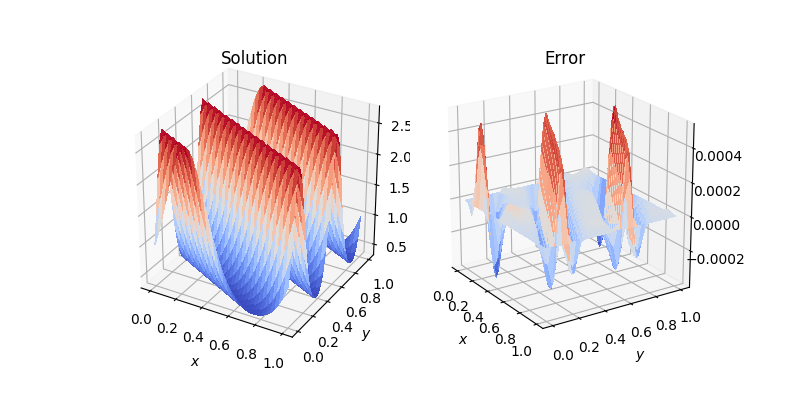

In [24]:
error = la.norm((us-us_exact).flatten())/la.norm(us_exact.flatten())
print(error)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1, projection='3d')
#surf1 = 
ax1.plot_surface(X,Y,us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Solution')
#fig.colorbar(surf)
#plt.show()

#fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(1,2,2, projection='3d')
#surf2 = 
ax2.plot_surface(X,Y,us-us_exact, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Error')
#fig.colorbar(surf)
plt.subplots_adjust(wspace=0)
plt.show()

In [12]:
ks = range(4,11)
ms = [2**k-1 for k in ks]
hs = [1/(m-1) for m in ms]
a, b = 0, 1

errors = []

for m in ms:
    print('m=%d' % m)
    us = fd2_poisson_compact(forcing, boundary, a, b, m)
    xs = np.linspace(a, b, m+2)
    X, Y = np.meshgrid(xs, xs)
    u_true = exact(X,Y)
    error = la.norm(us - u_true)/ la.norm(u_true)
    errors.append(error)

m=15
m=31
m=63
m=127
m=255
m=511
m=1023
	\begin{center}
		\begin{tabular}{|c|c|c|c|}
			\hline
			$k$&$m=2^k-1$&Relative $L^2$ Error&ratio\\ \hline
			4&15&0.0021715&-\\ \hline
			5&31&0.0001109&19.58\\ \hline
			6&63&6.6201e-06&16.753\\ \hline
			7&127&4.1065e-07&16.121\\ \hline
			8&255&2.5667e-08&15.999\\ \hline
			9&511&1.6058e-09&15.984\\ \hline
			10&1023&1.0066e-10&15.953\\ \hline
		\end{tabular}
	\end{center}
None


	\begin{center}
		\begin{tabular}{|c|c|c|c|}
			\hline
			$k$&$m=2^k-1$&Relative $L^2$ Error&ratio\\ \hline
			4&15&0.0021715&-\\ \hline
			5&31&0.0001109&19.58\\ \hline
			6&63&6.6201e-06&16.753\\ \hline
			7&127&4.1065e-07&16.121\\ \hline
			8&255&2.5667e-08&15.999\\ \hline
			9&511&1.6058e-09&15.984\\ \hline
			10&1023&1.0066e-10&15.953\\ \hline
		\end{tabular}
	\end{center}
None


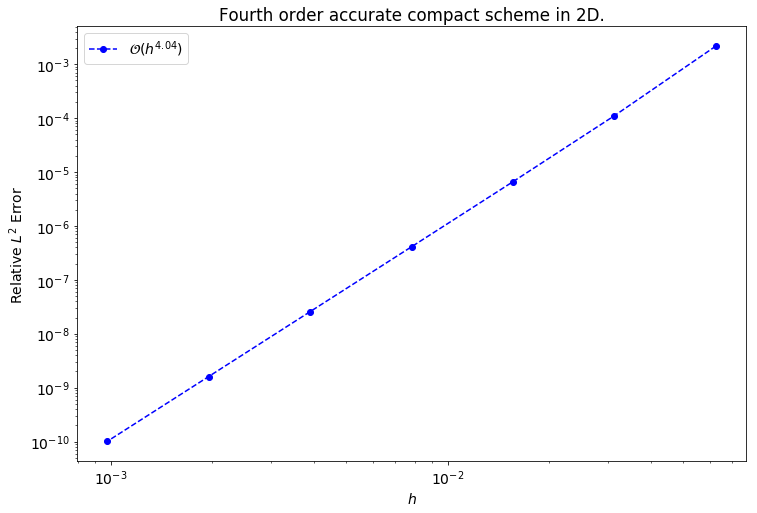

In [43]:
hs = [1/(m+1) for m in ms]
ratios = ['-'] + [e1/e2 for e1,e2 in zip(errors[:-1], errors[1:])]
print(latex_table([ks, ms, errors, ratios], ['$k$', '$m=2^k-1$', 'Relative $L^2$ Error', 'ratio']))

order = linreg(np.log(hs), np.log(errors))[0]

plt.figure(figsize=(12,8))
plt.loglog(hs, errors, 'bo--')
plt.legend(['$\mathcal{O}(h^{%.2f})$'%order])
#plt.xticks(hs[::2], ['$i=%d$'%i for i in range(num_ms)])
plt.xlabel('$h$')
plt.ylabel('Relative $L^2$ Error')
plt.title('Fourth order accurate compact scheme in 2D.')
plt.show()

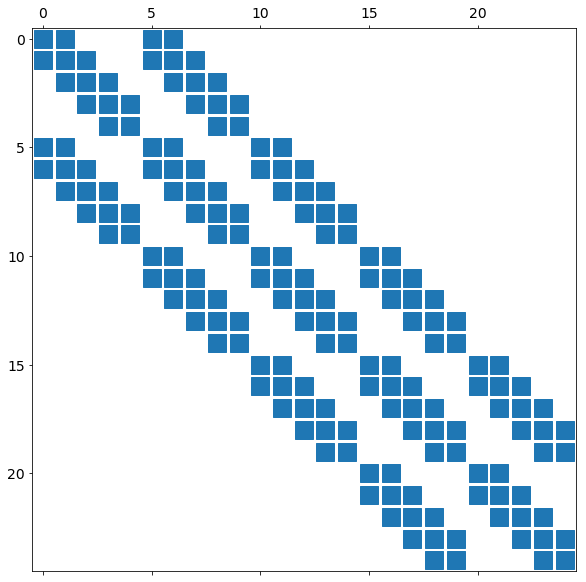

In [44]:
# Check the shape of the matrix
m = 5

diagonals = [4.0, -20, 4]
main_diag_val = sp.diags(diagonals, [-1,0,1], shape=(m,m), format='csr')
main_diag_loc = sp.eye(m)
diagonals = [1, 4, 1]
sub_diag_val = sp.diags(diagonals, [-1,0,1], shape=(m,m), format='csr')
sub_diag_loc = sp.diags([1,0,1], [-1, 0, 1], shape=(m,m), format='csr')

M = sp.kron(main_diag_val, main_diag_loc) + sp.kron(sub_diag_val, sub_diag_loc)

M = sp.kron(main_diag_val, main_diag_loc) + sp.kron(sub_diag_val, sub_diag_loc)
plt.figure(figsize=(10,10))
plt.spy(M, markersize=18)

# 4(c) - Extra Credit

In [28]:
def forcing(x,y):
    temp = 2*np.pi*(x+2*y)
    return 10*np.pi**2 * np.exp(np.sin(temp)) * (-2*np.sin(temp) + np.cos(2*temp)+1)
                                
def boundary(x,y):
    return np.exp(np.sin(2*np.pi*(x+2*y)))
exact = boundary

def fd2_poisson_compact_fast(forcing, boundary, a, b, m):
    h = (b-a)/(m+1)
    xs = np.linspace(a,b,m+2, endpoint=True)
    X,Y = np.meshgrid(xs,xs)
    fs = forcing(X,Y)
    us = boundary(X,Y)
    us[1:-1,1:-1] = np.zeros((m,m))

    rhs = np.zeros((m,m))
    # sum fs
    rhs +=   fs[1:-1,  :-2] # North
    rhs +=   fs[1:-1, 2:  ] # South
    rhs +=   fs[2:  , 1:-1] # East
    rhs +=   fs[ :-2, 1:-1] # West
    rhs += 8*fs[1:-1, 1:-1] # Center
    rhs *= h**2/2

    # account for boundary conditions
    # corners
    rhs_b = np.zeros((m,m))
    rhs_b += us[ :-2, :-2] # North-west
    rhs_b += us[ :-2,2:  ] # North-east
    rhs_b += us[2:  , :-2] # South-west
    rhs_b += us[2:  ,2:  ] # South-east
    # edges
    rhs_b += 4*us[1:-1,  :-2] # North
    rhs_b += 4*us[1:-1, 2:  ] # South
    rhs_b += 4*us[2:  , 1:-1] # East
    rhs_b += 4*us[ :-2, 1:-1] # West
    #center
    rhs_b += -20*us[1:-1, 1:-1] # Center

    rhs -= rhs_b #* 2/h**2
    
    f_hat = fft.idst(fft.dst(rhs, type=1, axis=0),type=1, axis=1)/(2*m+2)
    
    cos_vec = np.cos(np.pi*np.arange(1,m+1)/(m+1))
    denom =  4*np.multiply.outer(cos_vec, cos_vec)
    denom += 8*np.add.outer(cos_vec,cos_vec)
    denom -= 20
    
    u_hat = f_hat / denom
    #u_hat *= h**2/2
    us[1:-1,1:-1] = fft.dst(fft.idst(u_hat, type=1, axis=0),type=1, axis=1)/(2*m+2)
    return us

1.0042316011114462e-10


<IPython.core.display.Javascript object>


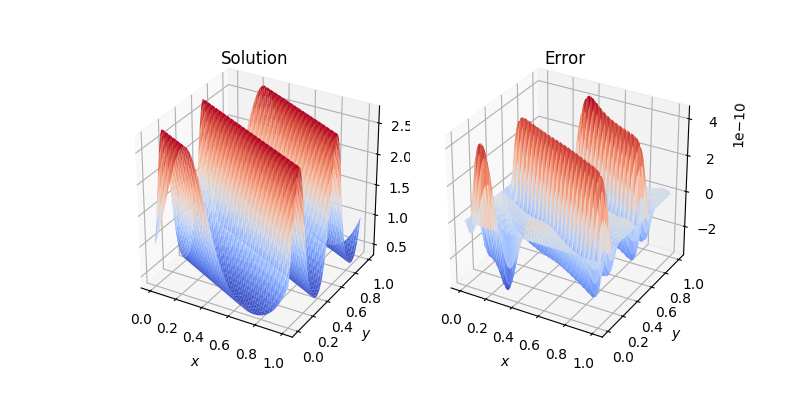

In [31]:
k = 10
a, b = 0, 1

m = 2**k-1
xs = np.linspace(a,b,m+2, endpoint=True)
X,Y = np.meshgrid(xs,xs)
us = fd2_poisson_compact_fast(forcing, boundary, a, b, m)
us_exact = exact(X,Y)

error = la.norm((us-us_exact).flatten())/la.norm(us_exact.flatten())
print(error)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1, projection='3d')
#surf1 = 
ax1.plot_surface(X,Y,us, cmap=cm.coolwarm)
#ax1.plot_surface(X[1:-1],Y[1:-1],us[1:-1], cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('Solution')
#fig.colorbar(surf)
#plt.show()

#fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(1,2,2, projection='3d')
#surf2 = 
ax2.plot_surface(X,Y,us-us_exact, cmap=cm.coolwarm)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('Error')
#fig.colorbar(surf)
plt.subplots_adjust(wspace=0)
plt.show()

In [51]:
%%capture
# comparison
ks = range(5, 11)
ms = [2**k-1 for k in ks]
a, b = 0, 1

differences = []
direct_times = []
dst_times = []
for m in ms:
    my_time = %timeit -n 1 -r 1 -o fd2_poisson_compact(forcing, boundary, a, b, m)
    direct_times += [my_time.best]
    my_time = %timeit -n 1 -r 1 -o fd2_poisson_compact_fast(forcing, boundary, a, b, m)
    dst_times += [my_time.best]
    us1 = fd2_poisson_compact(forcing, boundary, a, b, m)
    us2 = fd2_poisson_compact_fast(forcing, boundary, a, b, m)
    differences += [la.norm(us1-us2)/la.norm(us1)]

In [52]:
ms = [2**k-1 for k in ks]
latex_table([ks, ms, direct_times, dst_times, differences], ['$k$', '$m=2^k-1$', 'Direct Times', 'DST Time', 'Difference between direct and DST'])

	\begin{center}
		\begin{tabular}{|c|c|c|c|c|}
			\hline
			$k$&$m=2^k-1$&Direct Times&DST Time&Difference between direct and DST\\ \hline
			5&31&0.0077503&0.00086965&5.3381e-15\\ \hline
			6&63&0.027478&0.0017264&1.8458e-14\\ \hline
			7&127&0.1264&0.0046609&2.7774e-14\\ \hline
			8&255&0.88466&0.017388&3.5752e-13\\ \hline
			9&511&5.9126&0.062007&1.9227e-12\\ \hline
			10&1023&41.759&0.29983&3.6737e-12\\ \hline
		\end{tabular}
	\end{center}


# Multigrid

In [1]:
def foo(x,y):
    return -8*np.pi**2*np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

def exact(x,y):
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

In [ ]:


def fd2_multigrid(forcing, boundary, a, b, m):
    levels = 
    h = (b-a)/(m+1)
    xs = np.linspace(a, b, m+2)
    X, Y = np.meshgrid(xs, xs)
    us = boundary(X,Y)
    fs = foo(X, Y)
    
    
    return us

In [6]:
[i for i in range(5,-1,-1)]

[5, 4, 3, 2, 1, 0]

In [ ]:
m = 2**6-1
a, b = 0, 1

us = fd2poissondct(foo, a, b, m)
xs = np.linspace(a, b, m+2)
X, Y = np.meshgrid(xs, xs)
u_true = exact(X,Y)
error = la.norm(us - u_true)/ la.norm(u_true)
print(error)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#fig.colorbar(surf)
plt.show()